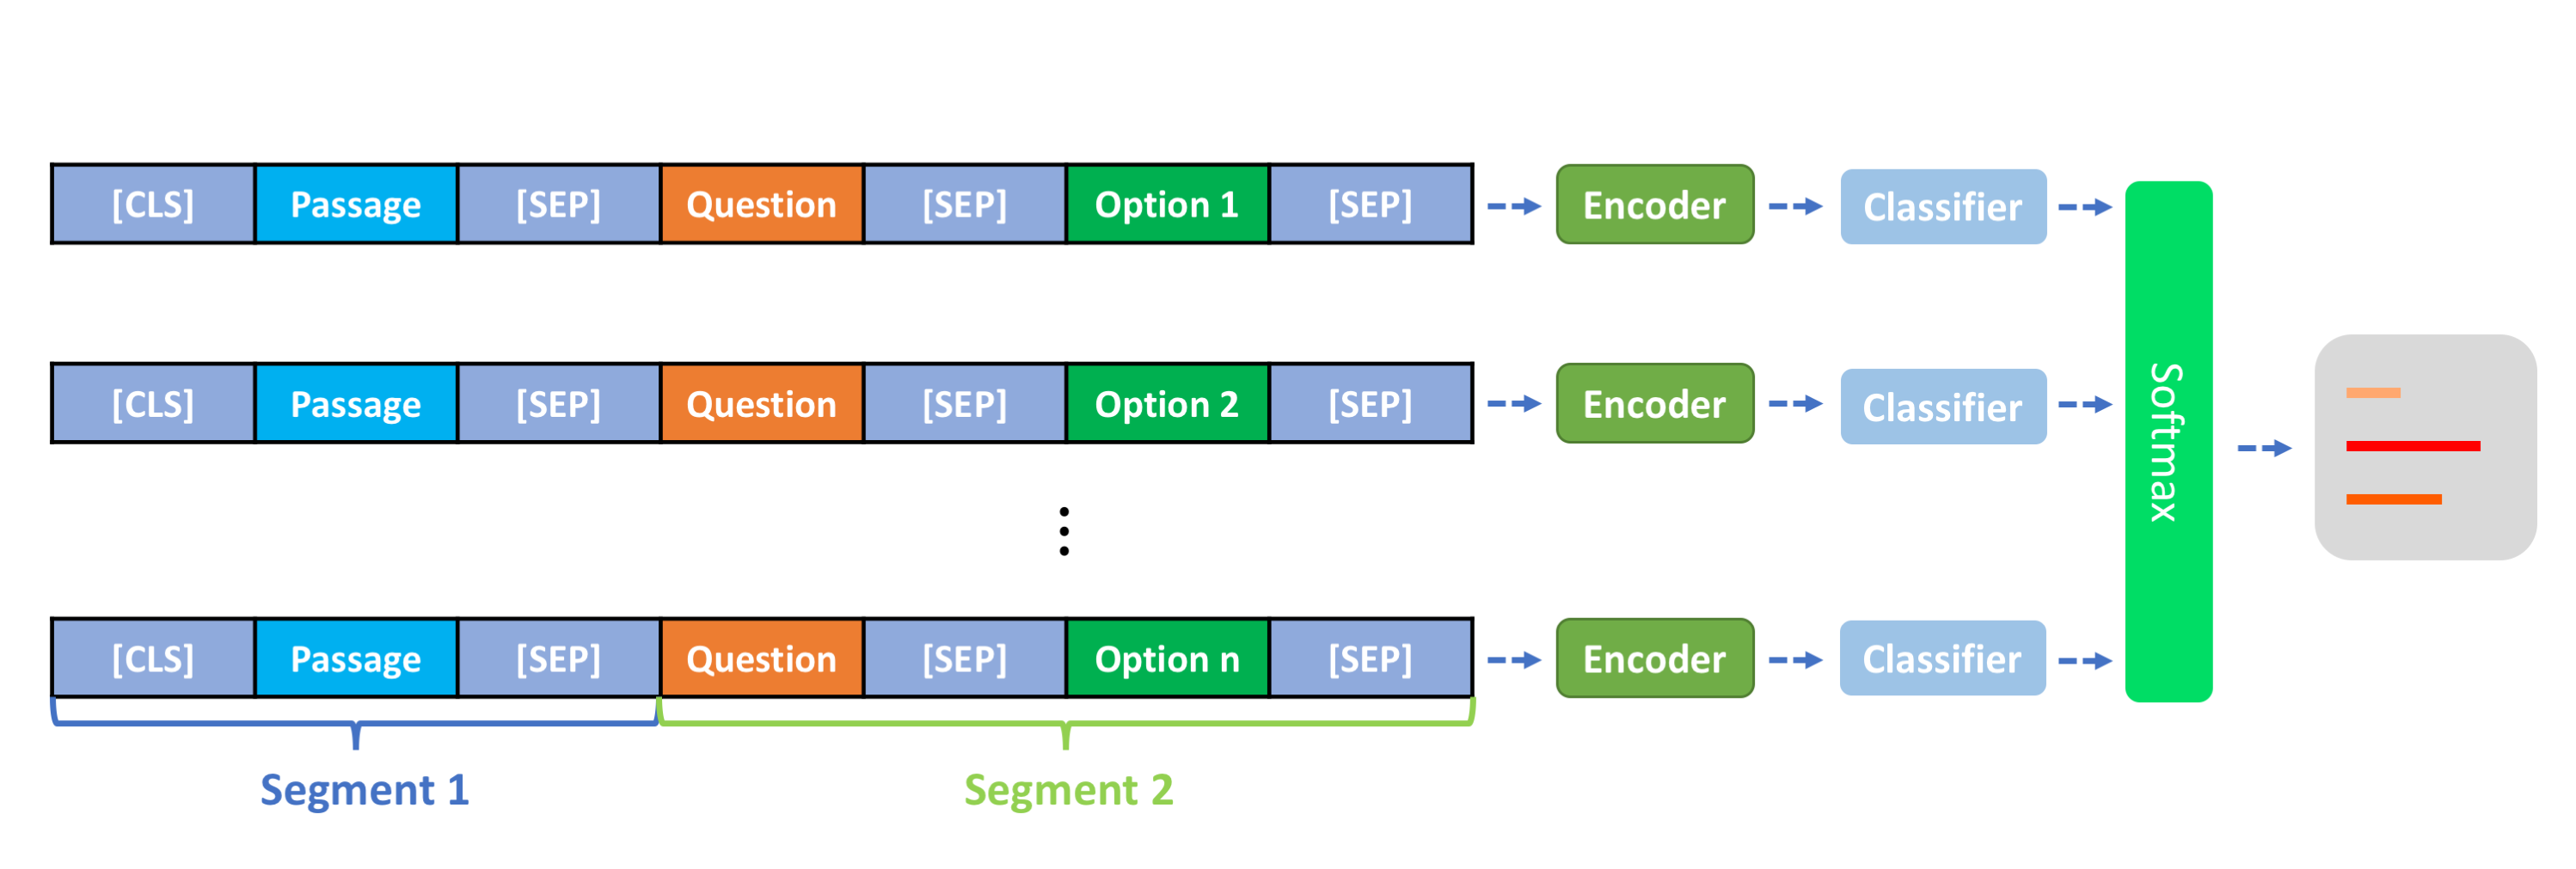

In [2]:
!wget https://storage.googleapis.com/cluebenchmark/tasks/c3_public.zip
!unzip c3_public.zip -d c3_public

Archive:  c3_public.zip
  inflating: c3_public/d-dev.json    
  inflating: c3_public/m-dev.json    
  inflating: c3_public/d-train.json  
  inflating: c3_public/m-train.json  
  inflating: c3_public/test.json     


In [1]:
import codecs
import json
import numpy as np

In [2]:
train = json.load(open('c3_public/d-train.json')) + json.load(open('c3_public/m-train.json'))
val = json.load(open('c3_public/m-dev.json')) + json.load(open('c3_public/d-dev.json'))

In [3]:
train_label = [x[1][0]['choice'].index(x[1][0]['answer']) for x in train]
val_label = [x[1][0]['choice'].index(x[1][0]['answer']) for x in val]

In [5]:
train[0]

[['男：你今天晚上有时间吗?我们一起去看电影吧?', '女：你喜欢恐怖片和爱情片，但是我喜欢喜剧片，科幻片一般。所以……'],
 [{'question': '女的最喜欢哪种电影?',
   'choice': ['恐怖片', '爱情片', '喜剧片', '科幻片'],
   'answer': '喜剧片'}],
 '25-35']

In [5]:
import torch
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese', num_choices=4)
# train_encoding = tokenizer(list(train_lines), truncation=True, padding=True, max_length=64)
# val_encoding = tokenizer(list(val_lines), truncation=True, padding=True, max_length=64)

In [6]:
def collate_fn(data): #将文章问题选项拼在一起后，得到分词后的数字id，输出的size是(batch, n_choices, max_len)
    input_ids, attention_mask, token_type_ids = [], [], []
    for x in data:
        text = tokenizer(x[1], text_pair=x[0], padding='max_length', truncation=True, 
                         max_length=128, return_tensors='pt')
        input_ids.append(text['input_ids'].tolist())
        attention_mask.append(text['attention_mask'].tolist())
        token_type_ids.append(text['token_type_ids'].tolist())
    input_ids = torch.tensor(input_ids)
    attention_mask = torch.tensor(attention_mask)
    token_type_ids = torch.tensor(token_type_ids)
    label = torch.tensor([x[-1] for x in data])
    return input_ids, attention_mask, token_type_ids, label

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

class TextDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __getitem__(self, idx):
        label = self.labels[idx]
        question = self.data[idx][1][0]['question']
        content = '。'.join(self.data[idx][0])
        choice = self.data[idx][1][0]['choice']
        if len(choice) < 4: #如果选项不满四个，就补“不知道”
            for i in range(4-len(choice)):
                choice.append('不知道')
        
        content = [content for i in range(len(choice))]
        pair = [question + ' ' + i for i in choice]
        
        return content, pair, label
    
    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train, train_label)
test_dataset = TextDataset(val, val_label)

In [8]:
train_dataset[100]

(['男：小王，会议手册做得怎么样了?。女：除了通讯录，其他部分基本上都完成了。现在只有通讯录的信息还不全。',
  '男：小王，会议手册做得怎么样了?。女：除了通讯录，其他部分基本上都完成了。现在只有通讯录的信息还不全。',
  '男：小王，会议手册做得怎么样了?。女：除了通讯录，其他部分基本上都完成了。现在只有通讯录的信息还不全。',
  '男：小王，会议手册做得怎么样了?。女：除了通讯录，其他部分基本上都完成了。现在只有通讯录的信息还不全。'],
 ['关于会议手册，下列哪项正确? 已经完成了',
  '关于会议手册，下列哪项正确? 包含通讯录',
  '关于会议手册，下列哪项正确? 一共有15页',
  '关于会议手册，下列哪项正确? 需要重新打印'],
 1)

In [9]:
import torch
from transformers import BertForMultipleChoice, AdamW, get_linear_schedule_with_warmup
model = BertForMultipleChoice.from_pretrained('bert-base-chinese')

# device = 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-chinese and are newly

BertForMultipleChoice(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [10]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

optim = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_loader) * 1
scheduler = get_linear_schedule_with_warmup(optim, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [12]:
from tqdm import tqdm

def train():
    model.train()
    total_train_loss = 0
    iter_num = 0
    total_iter = len(train_loader)
    for idx, (input_ids, attention_mask, token_type_ids, labels) in enumerate(train_loader):
        optim.zero_grad()
        
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        # print(labels)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            # loss = outputs[0]

        # print(outputs[1])
        loss = outputs.loss
        
        if idx % 20 == 0:
            with torch.no_grad():
                # 64 * 7
                print((outputs[1].argmax(1).data == labels.data).float().mean().item(), loss.item())
        
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optim.step()
        scheduler.step()

        iter_num += 1
        if(iter_num % 100 ==0):
            print("epoth: %d, iter_num: %d, loss: %.4f, %.2f%%" % (epoch, iter_num, loss.item(), iter_num/total_iter*100))
        
    print("Epoch: %d, Average training loss: %.4f"%(epoch, total_train_loss/len(train_loader)))
    
def validation():
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    for (input_ids, attention_mask, token_type_ids, labels) in test_dataloader:
        with torch.no_grad():
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs[1]

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        total_eval_accuracy += (outputs[1].argmax(1).data == labels.data).float().mean().item()
        
    avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
    print("Accuracy: %.4f" % (avg_val_accuracy))
    print("Average testing loss: %.4f"%(total_eval_loss/len(test_dataloader)))
    print("-------------------------------")
    

for epoch in range(4):
    print("------------Epoch: %d ----------------" % epoch)
    validation()
    train()
    

------------Epoch: 0 ----------------
Accuracy: 0.5157
Average testing loss: 1.0542
-------------------------------
0.25 1.2708765268325806
0.5 1.2187812328338623
0.75 0.8115807771682739
0.125 1.6748816967010498
0.5 1.0075186491012573
epoth: 0, iter_num: 100, loss: 0.9920, 9.97%
0.625 0.8167418241500854
0.75 0.5969402194023132
0.625 0.8233251571655273
0.375 1.2235373258590698
0.25 1.2308274507522583
epoth: 0, iter_num: 200, loss: 0.9812, 19.94%
0.625 0.8401491045951843
0.875 1.0532958507537842
0.5 1.102265477180481
0.75 0.7831389307975769
0.75 0.9182713627815247
epoth: 0, iter_num: 300, loss: 0.9015, 29.91%
0.75 0.8305198550224304
0.75 0.7400080561637878
0.625 1.0912903547286987
0.375 0.9870917201042175
0.625 1.1895976066589355
epoth: 0, iter_num: 400, loss: 0.5489, 39.88%
0.375 1.3164583444595337
0.75 0.9166025519371033
0.5 1.0236040353775024
0.625 1.0010851621627808
0.375 0.8135765194892883
epoth: 0, iter_num: 500, loss: 0.7646, 49.85%
0.625 0.8594875931739807
0.5 0.8489070534706116


KeyboardInterrupt: 